In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

# reload utils to get the latest version of the functions
import importlib
import utils
importlib.reload(utils)

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from scipy import stats


import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats


In [2]:
def train_model(feature_names=["RESP", "NG_Price", "BESS"], outcome="Imbalance",
                            historical_data_path="processed_data/historical_data.csv", show_summary=True, scale=True):
    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)
    historical_data["month"] = historical_data.index.month

    # Monthly dummies (excluding the first to avoid multicollinearity)
    month_dummies = pd.get_dummies(historical_data["month"], prefix="Month", drop_first=True)

    # Features and target
    X = pd.concat([historical_data[feature_names], month_dummies], axis=1).astype(float)
    y = historical_data[outcome]

    # Remove outliers
    z = np.abs(stats.zscore(y))
    threshold = 3
    outliers = np.where(z > threshold)[0]
    X = X.drop(X.index[outliers])
    y = y.drop(y.index[outliers])

    #Feature scaling
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X_scaled = scaler.fit_transform(X)
        X_const = sm.add_constant(X_scaled)
    else:
        X_const = sm.add_constant(X)
        scaler=None

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5, gap = 4)
    model = RidgeCV(cv=tscv, store_cv_results=False, alphas=np.logspace(-2, 2, 50)).fit(X_const, y)

    # Best model metrics
    best_alpha = model.alpha_
    y_pred = model.predict(X_const)
    mae = mean_absolute_error(y, y_pred)

    #HISTORICAL RESIDUALS
    residuals = y - y_pred

    if show_summary:
        print(f"✅ Best Alpha: {best_alpha}")
        print(f"✅ Mean Absolute Error on Full Data: {mae:.4f}")

    return model, residuals, scaler

In [3]:
def forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", feature_names=["RESP", "NG_Price", "BESS", "EUA"],
                            future_data_path="processed_data/Future dataset with BESS.csv",
                            historical_data_path="processed_data/historical_data.csv",
                            show_plot=True):
    """
    Forecasts future scenarios using the trained model and specified features, including monthly dummies.
    Incorporates volatility by adjusting forecasts based on historical residuals.
    """
    future_data = pd.read_csv(future_data_path, parse_dates=["Date"])
    future_data["month"] = future_data["Date"].dt.month

    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)

    # Prepare month dummies (must match training: months 2–12, drop January)
    month_dummies = pd.get_dummies(future_data["month"], prefix="Month", drop_first=True)

    # Mapping future scenario columns to standardized features
    scenario_mapping = {
        "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
        "NG_Price": ["Ga", "Gb", "Gc"],
        "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"],
    }

    scenario_combinations = list(itertools.product(
        *[scenario_mapping[key] for key in scenario_mapping.keys()]
    ))

    # Get the standard deviation of the residuals to incorporate volatility
    residuals_std = residuals.std()

    future_combination_dfs = []
    for combination in scenario_combinations:
        combination_name = "_".join(combination)

        try:
            # Base features
            temp_df = pd.DataFrame({
                "RESP": future_data[combination[0]].values,
                "NG_Price": future_data[combination[1]].values,
                "BESS": future_data[combination[2]].values,
            })

            # Combine with month dummies
            X_future = pd.concat([temp_df, month_dummies], axis=1)

            if scaler == None:
                x_future_scaled = sm.add_constant(X_future).astype(float)
            else:
                x_future_scaled = scaler.transform(X_future)
                x_future_scaled = sm.add_constant(x_future_scaled).astype(float)

            # Predict revenue
            revenue_forecast = model.predict(x_future_scaled)

            # Adjust forecast for volatility (adding/subtracting based on residual std)
            adjusted_forecast = revenue_forecast + residuals_std * np.random.randn(len(revenue_forecast))

            # Store forecast
            future_comb_df = pd.DataFrame({
                "Date": future_data["Date"],
                f"Total Revenue Forecast ({combination_name})": adjusted_forecast
            })
            future_combination_dfs.append(future_comb_df.set_index("Date"))

        except KeyError as e:
            print(f"Missing column in combination {combination}: {e}")
            continue

    all_forecasts = pd.concat(future_combination_dfs, axis=1)

    if show_plot:
        plt.figure(figsize=(20, 5))
        plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
        for column in all_forecasts.columns:
            plt.plot(all_forecasts.index, all_forecasts[column], label=column)
        plt.title(f"Forecasts for {outcome} Revenue Across Scenarios")
        plt.grid(True)
        plt.show()

    return all_forecasts

✅ Best Alpha: 100.0
✅ Mean Absolute Error on Full Data: 1986.0271


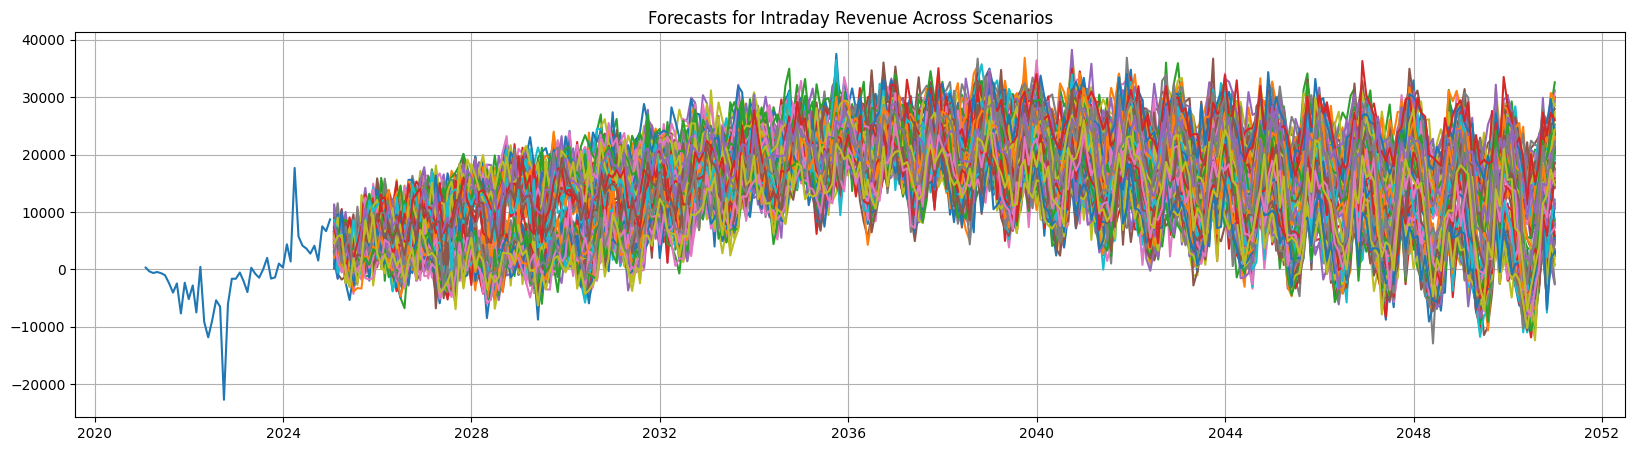

✅ Best Alpha: 22.229964825261934
✅ Mean Absolute Error on Full Data: 5503.9948


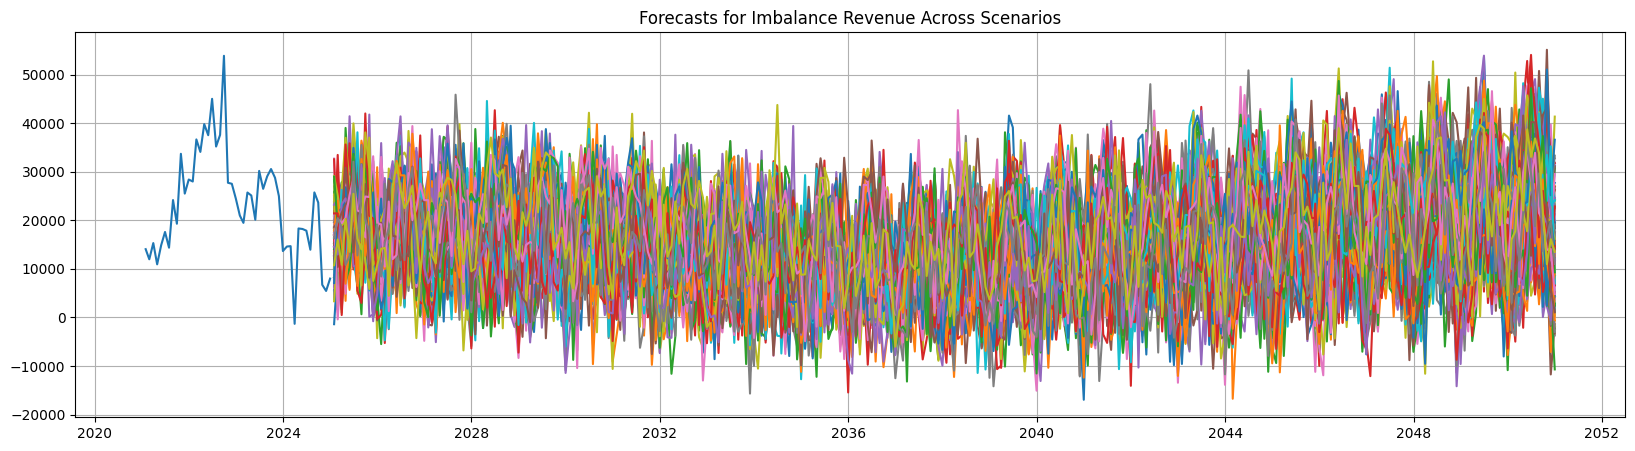

✅ Best Alpha: 0.9102981779915218
✅ Mean Absolute Error on Full Data: 138.2138


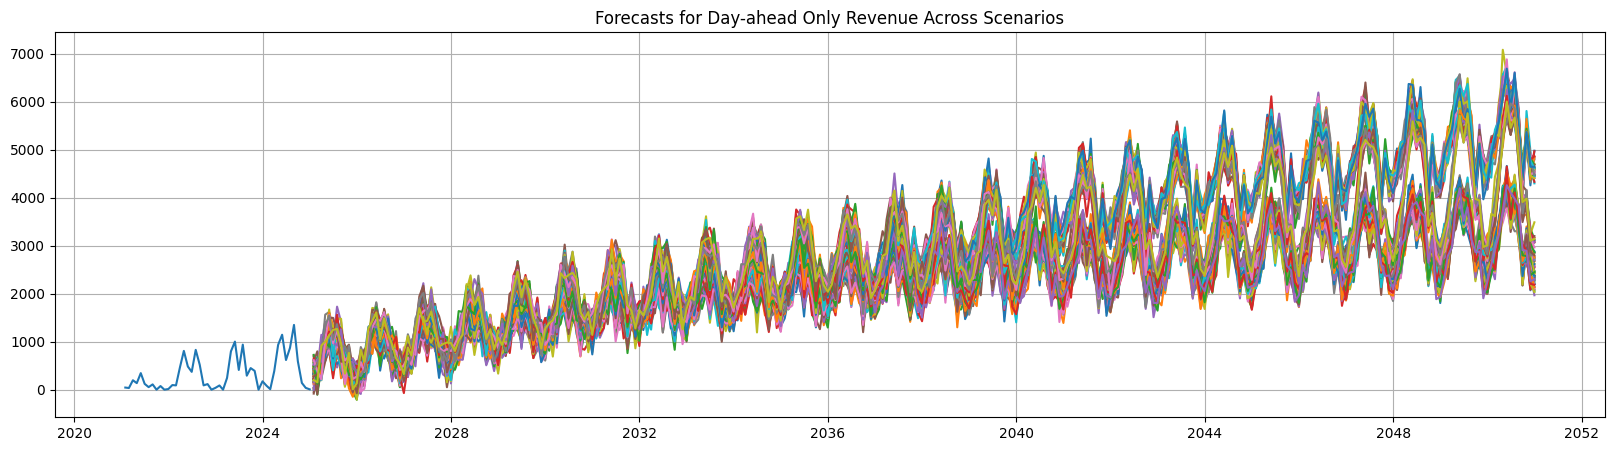

In [9]:
model, residuals, scaler = train_model(outcome="Intraday", show_summary=True, scale=False)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Intraday")
forecasts.to_csv("forecasts/intraday_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Imbalance", show_summary=True)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance")
forecasts.to_csv("forecasts/imbalance_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Day-ahead Only", show_summary=True)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Day-ahead Only")
forecasts.to_csv("forecasts/day_ahead_revenue_forecasts_combined.csv")

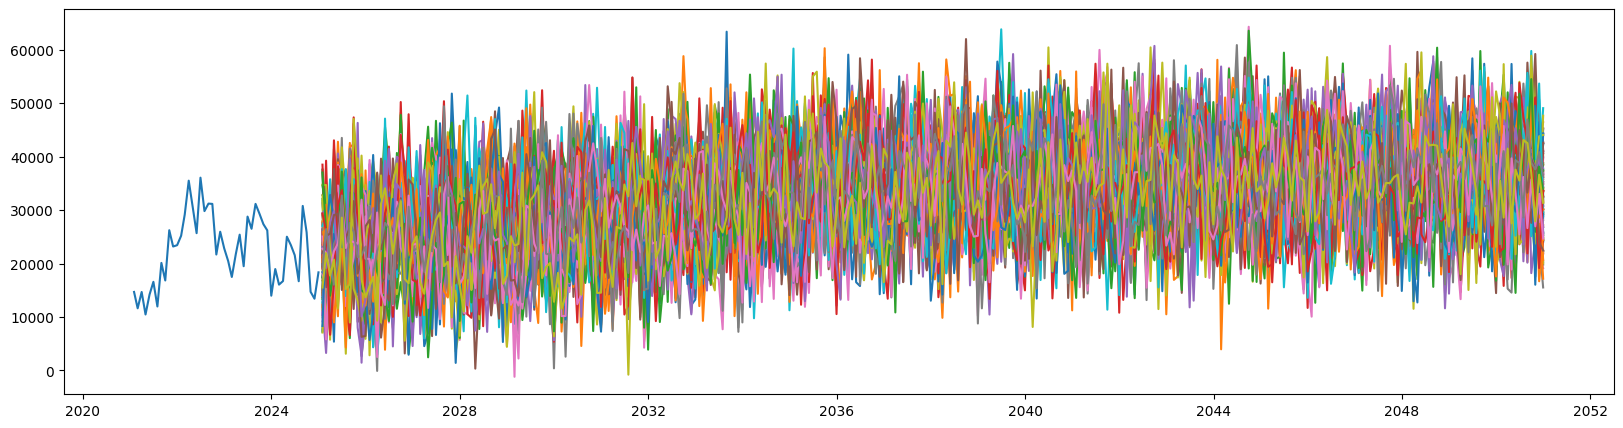

In [10]:
imbalance_revenue_forecasts = pd.read_csv("forecasts/imbalance_revenue_forecasts_combined.csv", parse_dates=["Date"])
imbalance_revenue_forecasts.set_index("Date", inplace=True)
day_ahead_revenue_forecasts = pd.read_csv("forecasts/day_ahead_revenue_forecasts_combined.csv", parse_dates=["Date"])
day_ahead_revenue_forecasts.set_index("Date", inplace=True)
intraday_revenue_forecasts = pd.read_csv("forecasts/intraday_revenue_forecasts_combined.csv", parse_dates=["Date"])
intraday_revenue_forecasts.set_index("Date", inplace=True)

total_revenue = pd.DataFrame(index = imbalance_revenue_forecasts.index, columns = day_ahead_revenue_forecasts.columns)
total_revenue.index.name = "Date"

for i in range(len(total_revenue.columns)):
    total_revenue.iloc[:, i] = imbalance_revenue_forecasts.iloc[:, i] + day_ahead_revenue_forecasts.iloc[:, i] + intraday_revenue_forecasts.iloc[:, i]

# Load historical dataset
historical_data = pd.read_csv("processed_data/historical_data.csv", parse_dates=["Date"])
historical_data.set_index("Date", inplace=True)

# Plot historical data
plt.figure(figsize=(20, 5))
plt.plot(historical_data.index, historical_data["Total"], label="Historical Revenue")

for column in total_revenue.columns:
    plt.plot(total_revenue.index, total_revenue[column], label=column)
plt.show()

total_revenue.to_csv("forecasts/total_revenue_summed_forecasts_combined.csv")